# Hair dryer System ident

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Proyecto_Splra')

Mounted at /content/drive


In [2]:
cd SIPPY-master/

/content/drive/MyDrive/Proyecto_Splra/SIPPY-master


In [3]:
!pip install scikit-build
!pip install setuptools_scm
!pip install control -U
!pip install scienceplots
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended texlive-latex-recommended cm-super

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.1/455.1 kB 4.9 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern
  pfb2t1c2pfb poppler-data preview-latex-style rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils
  tex-common tex-gyre texlive-base te

In [4]:
!python setup.py install

running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based t

In [5]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import time
import matplotlib as mpl

import sys
sys.path.append('/content/drive/MyDrive/Proyecto_Splra/Python')
mpl.rcParams['lines.linewidth'] = 0.6

from Sparse_Sys_Id import *
from Lra_Modeling import *
from Sparse_Lra import *
from sklearn.metrics import r2_score
import control as cnt

In [6]:
data= np.loadtxt( '/content/drive/MyDrive/Proyecto_Splra/Data/dryer.dat' )
data.shape

(1000, 2)

array([<Axes: >, <Axes: >], dtype=object)

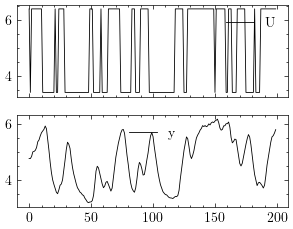

In [7]:
df=pd.DataFrame(data,columns=['U','y'])
df[:200].plot(subplots=True,color='k')

In [8]:
ntest=int(0.50*len(df))
wtrain,wtest=df[:-ntest],df[-ntest:]

## LRA Modeling

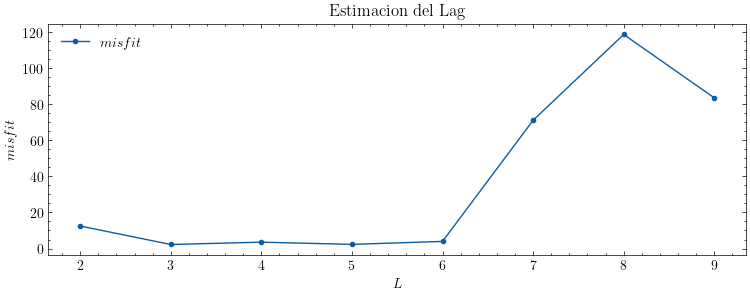

In [11]:
lag_est(wtrain.values.T,10,1,1e-2,1e-2)

In [9]:
L=5

In [10]:
M,fit,wh,R_sp,sys_tf,sys_ss,x0=Sparse_lra_sysid(wtrain.values.T,L,1,tol=1e-2,delta=1e-2)

In [11]:
M,fit

(2.3219384257094084, 93.94797949702101)

In [12]:
Xdf_id = pd.DataFrame(wh.T, columns=['Uid','Y_id'])

array([<Axes: >, <Axes: >], dtype=object)

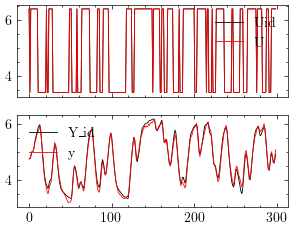

In [16]:
ax=Xdf_id[:300].plot(subplots=True,color='k')
df[:300].plot(ax=ax,subplots=True,color='r')

(array([0.11654862+0.88555373j, 0.11654862-0.88555373j,
        0.83250229+0.j        , 0.62556405+0.39856145j,
        0.62556405-0.39856145j]),
 array([0.17996227+0.6949118j, 0.17996227-0.6949118j]))

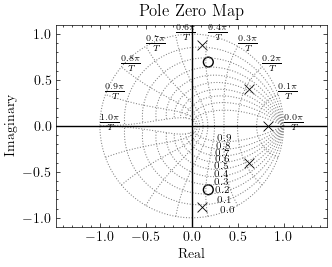

In [26]:
cnt.pzmap(sys_tf,grid=True)

In [13]:
sys_tf

TransferFunction(array([ 0.06573056, -0.02365804,  0.03387022]), array([ 1.        , -2.31672762,  2.87522609, -2.49135704,  1.37664446,
       -0.36540926]), 1)

In [14]:
t,y=ctl.forced_response(sys_ss,U=df.values[:,:1].T,X0=x0)

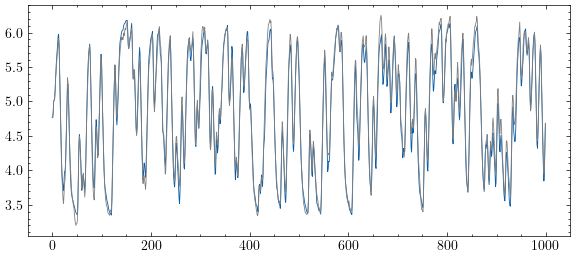

In [29]:
plt.figure(figsize=(7,3))
plt.plot(y)
plt.plot(df.values[:,-1],color='gray')

In [15]:
wh_test = np.block([[wtest.values.T[0:1,:]],[y[-ntest:]]])

In [16]:
1-la.norm(wtest.values.T-wh_test)/la.norm(wtest-np.mean(wtest.values))

0.9224047173236808

In [17]:
sparsity_ss(sys_ss)

36.11111111111111

## Sippy Arx

In [18]:
from sippy import *
from sippy import functionset as fset

In [19]:
wtrain0 = signal.detrend(wtrain.values.T)
wtest0  = signal.detrend(wtest.values.T)

In [20]:
wtrain0.shape

(2, 500)

In [21]:
Id_ARX = system_identification(wtrain0[1,:],wtrain0[0,:], 'ARX', IC='AIC')

suggested orders are: Na= 5 ; Nb= 4 Delay:  1


In [22]:
Y1, Time, Xsim = cnt.matlab.lsim(Id_ARX.G, U=signal.detrend(df.values[:,0]))

(array([-0.35371783+0.41636741j, -0.35371783-0.41636741j,
         0.7555009 +0.j        ,  0.43916849+0.17991257j,
         0.43916849-0.17991257j]),
 array([-16.24976839+0.j        ,  -0.51926075+0.38378369j,
         -0.51926075-0.38378369j]))

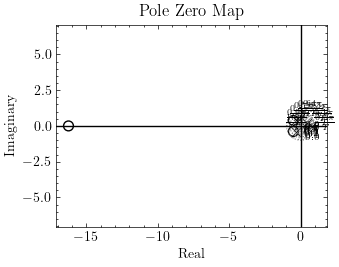

In [23]:
cnt.pzmap(Id_ARX.G,grid=True)

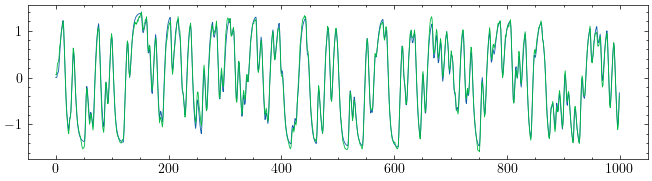

In [24]:
plt.figure(figsize=(8,2))
plt.plot(Y1[:])
plt.plot(signal.detrend(df.values[:,1]))

In [25]:
1-(la.norm(wtrain0[1,:]-Y1[:-ntest]))/la.norm(wtrain0[1,:]-np.mean(wtrain0[1,:]))

0.8745249987396262

In [26]:
1-(la.norm(wtest0[1,:]-Y1[-ntest:]))/la.norm(wtest0[1,:]-np.mean(wtest0[1,:]))

0.8239355835154988

In [27]:
sparsity_ss(ctl.tf2ss(Id_ARX.G))

38.88888888888889

## Sippy N4sid

In [28]:
sys_n4sid= system_identification(wtrain0[1,:], wtrain0[0,:],'N4SID',SS_fixed_order = 5)

In [29]:
sys_n4sid_ss=ctl.ss(sys_n4sid.A,sys_n4sid.B,sys_n4sid.C,sys_n4sid.D,1)

In [30]:
t,y_n4sid = ctl.forced_response(sys_n4sid_ss, U=signal.detrend(df.values[:,0]))

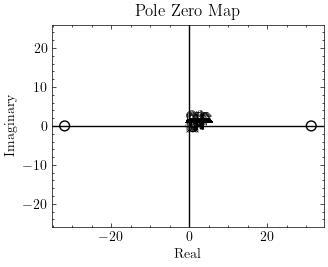

In [31]:
cnt.pzmap(sys_n4sid_ss,grid=True)
plt.show()

In [32]:
1-(la.norm(wtrain0[1,:]-y_n4sid[:-ntest])/(la.norm(wtrain0[1,:]-np.mean(wtrain0[1,:]))))

0.8759412092410137

In [33]:
1-(la.norm(wtest0[1,:]-y_n4sid[-ntest:])/(la.norm(wtest0[1,:]-np.mean(wtest0[1,:]))))

0.8211075794882985

In [34]:
sparsity_ss(sys_n4sid_ss)

97.22222222222221